# Import packages

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

plt.style.use('ggplot')

from tqdm import tqdm
from collections import Counter

from phenotype_preprocess import *
from plot_utils import plot_medicines, plot_one_medicine

In [4]:
# info_drug = pd.read_csv('drug_phenotype_data.csv')
# {name: short_name for name, short_name in zip(info_drug["realNames"], info_drug["drugShortNames"])}

# Open data

In [5]:
path = './data/'

In [6]:
drug_phenotype_df = pd.read_csv(path + 'drug_phenotype_data.csv') 
#information about drugs (name, phenotype, dose, etc.)

In [7]:
#make separate variables for important columns for simplicity

y_raw_interpol = drug_phenotype_df['Raw Y (interpolation to 70)'] / 100
drug_doses  = drug_phenotype_df['dose (uM)']
drug_labels = drug_phenotype_df['dose (label)']
drug_names = drug_phenotype_df['drugShortNames']

# Preprocess Kinases

From empirical considerations we understand that phenotype depends on the dose of a drug like a sigmoid: 

(1) almost no inhibition at small doses (plateau at the start of the inhibition profile),

(2) close to linear decrease at intermediate doses, 

(3) no change of inhibition level after a sufficiently large dose (plateau at the end of the profile). 

The notion of an "intermediate" and "sufficiently large" dose appeared to significantly vary from drug to drug. For example, many drugs do not influence the phenotype even at large doses, in this case inhibition profile looks like a horizontal line, i.e. the second and third phases are not reached at all. Apparently, drugs with "full" inhibition profiles keep the most essential information about the phenotype, while drugs with horizontal profiles often but not always correspond to less informative or even unpredictable phenotypes. These considerations motivate careful selection of informative drugs and their preprocessing forming sigmoid-like profile shapes. Because of high noisiness of the collected phenotype data, it is extremely hard to propose a general automatic approach for its preprocessing, so in the present work both selection and sigmoiding of the profiles were done manually.

In [8]:
# Manually define doses at which the starting plateau ends
drug_2_starting_plateau_finish_dose = {
'A1': 0.12, 'E1': 0, 'H1': 0.37, 'C2': 0.37, 'G2': 0.12, 'C3': 3.3, 
'F3': 0.37, 'F4': 0.37, 'B5': 10, 'G6': 0.37, 'A7' : 0.12, 'F1': 10,
'D2': 10, 'G4': 1.11, 'H5': 3.3, 'C6': 0.12, 'H6': 0.04, 'D7' : 3.3, 
'G1': 10, 'B3': 10, 'G3': 0.12, 'C7': 0.37, 'B1': 3.3, 'F2': 0, 
'F7': 1.11, 'D1': 10, 'A2': 0.04, 'B2': 3.3, 'E3':  0.12, 'C1': 3.3,
'H4': 1.11, 'D5': 3.3, 'E5': 0, 'D3': 10, 'H3': 0, 'A4': 0.04,
'B4': 3.3, 'H2':  0, 'A3': 10, 'D4': 0.12, 'A6': 0, 'B6': 10, 
'E7': 0.12, 'A8': 0.12, 'E2': 0.12, 'E4': 10,'C5': 0.12 ,'C4': 0.12, 
'F5': 10, 'G5': 3.3, 'D6': 10, 'E6': 1.11, 'F6': 0, 'B7': 0.12, 
 'A5': 0.12, 'H7': 0.12}

In [9]:
y = preprocess_phenotype(y_raw_interpol, drug_doses, drug_names, 
                                drug_2_starting_plateau_finish=drug_2_starting_plateau_finish_dose)

# phenotypes of some drugs apparently have lower values than they should, 
# so we shift up all values by a constant so that the profcile starts around 0.7 (control value)
#y[(drug_names == 'F6') & (drug_doses != 0)] += 0.7 - y[(drug_names == 'F6') & (drug_doses == 0.01)].item()

# save the variable
y.rename('Y').to_csv(path + 'y_plateau_preprocessed.csv', index=False)

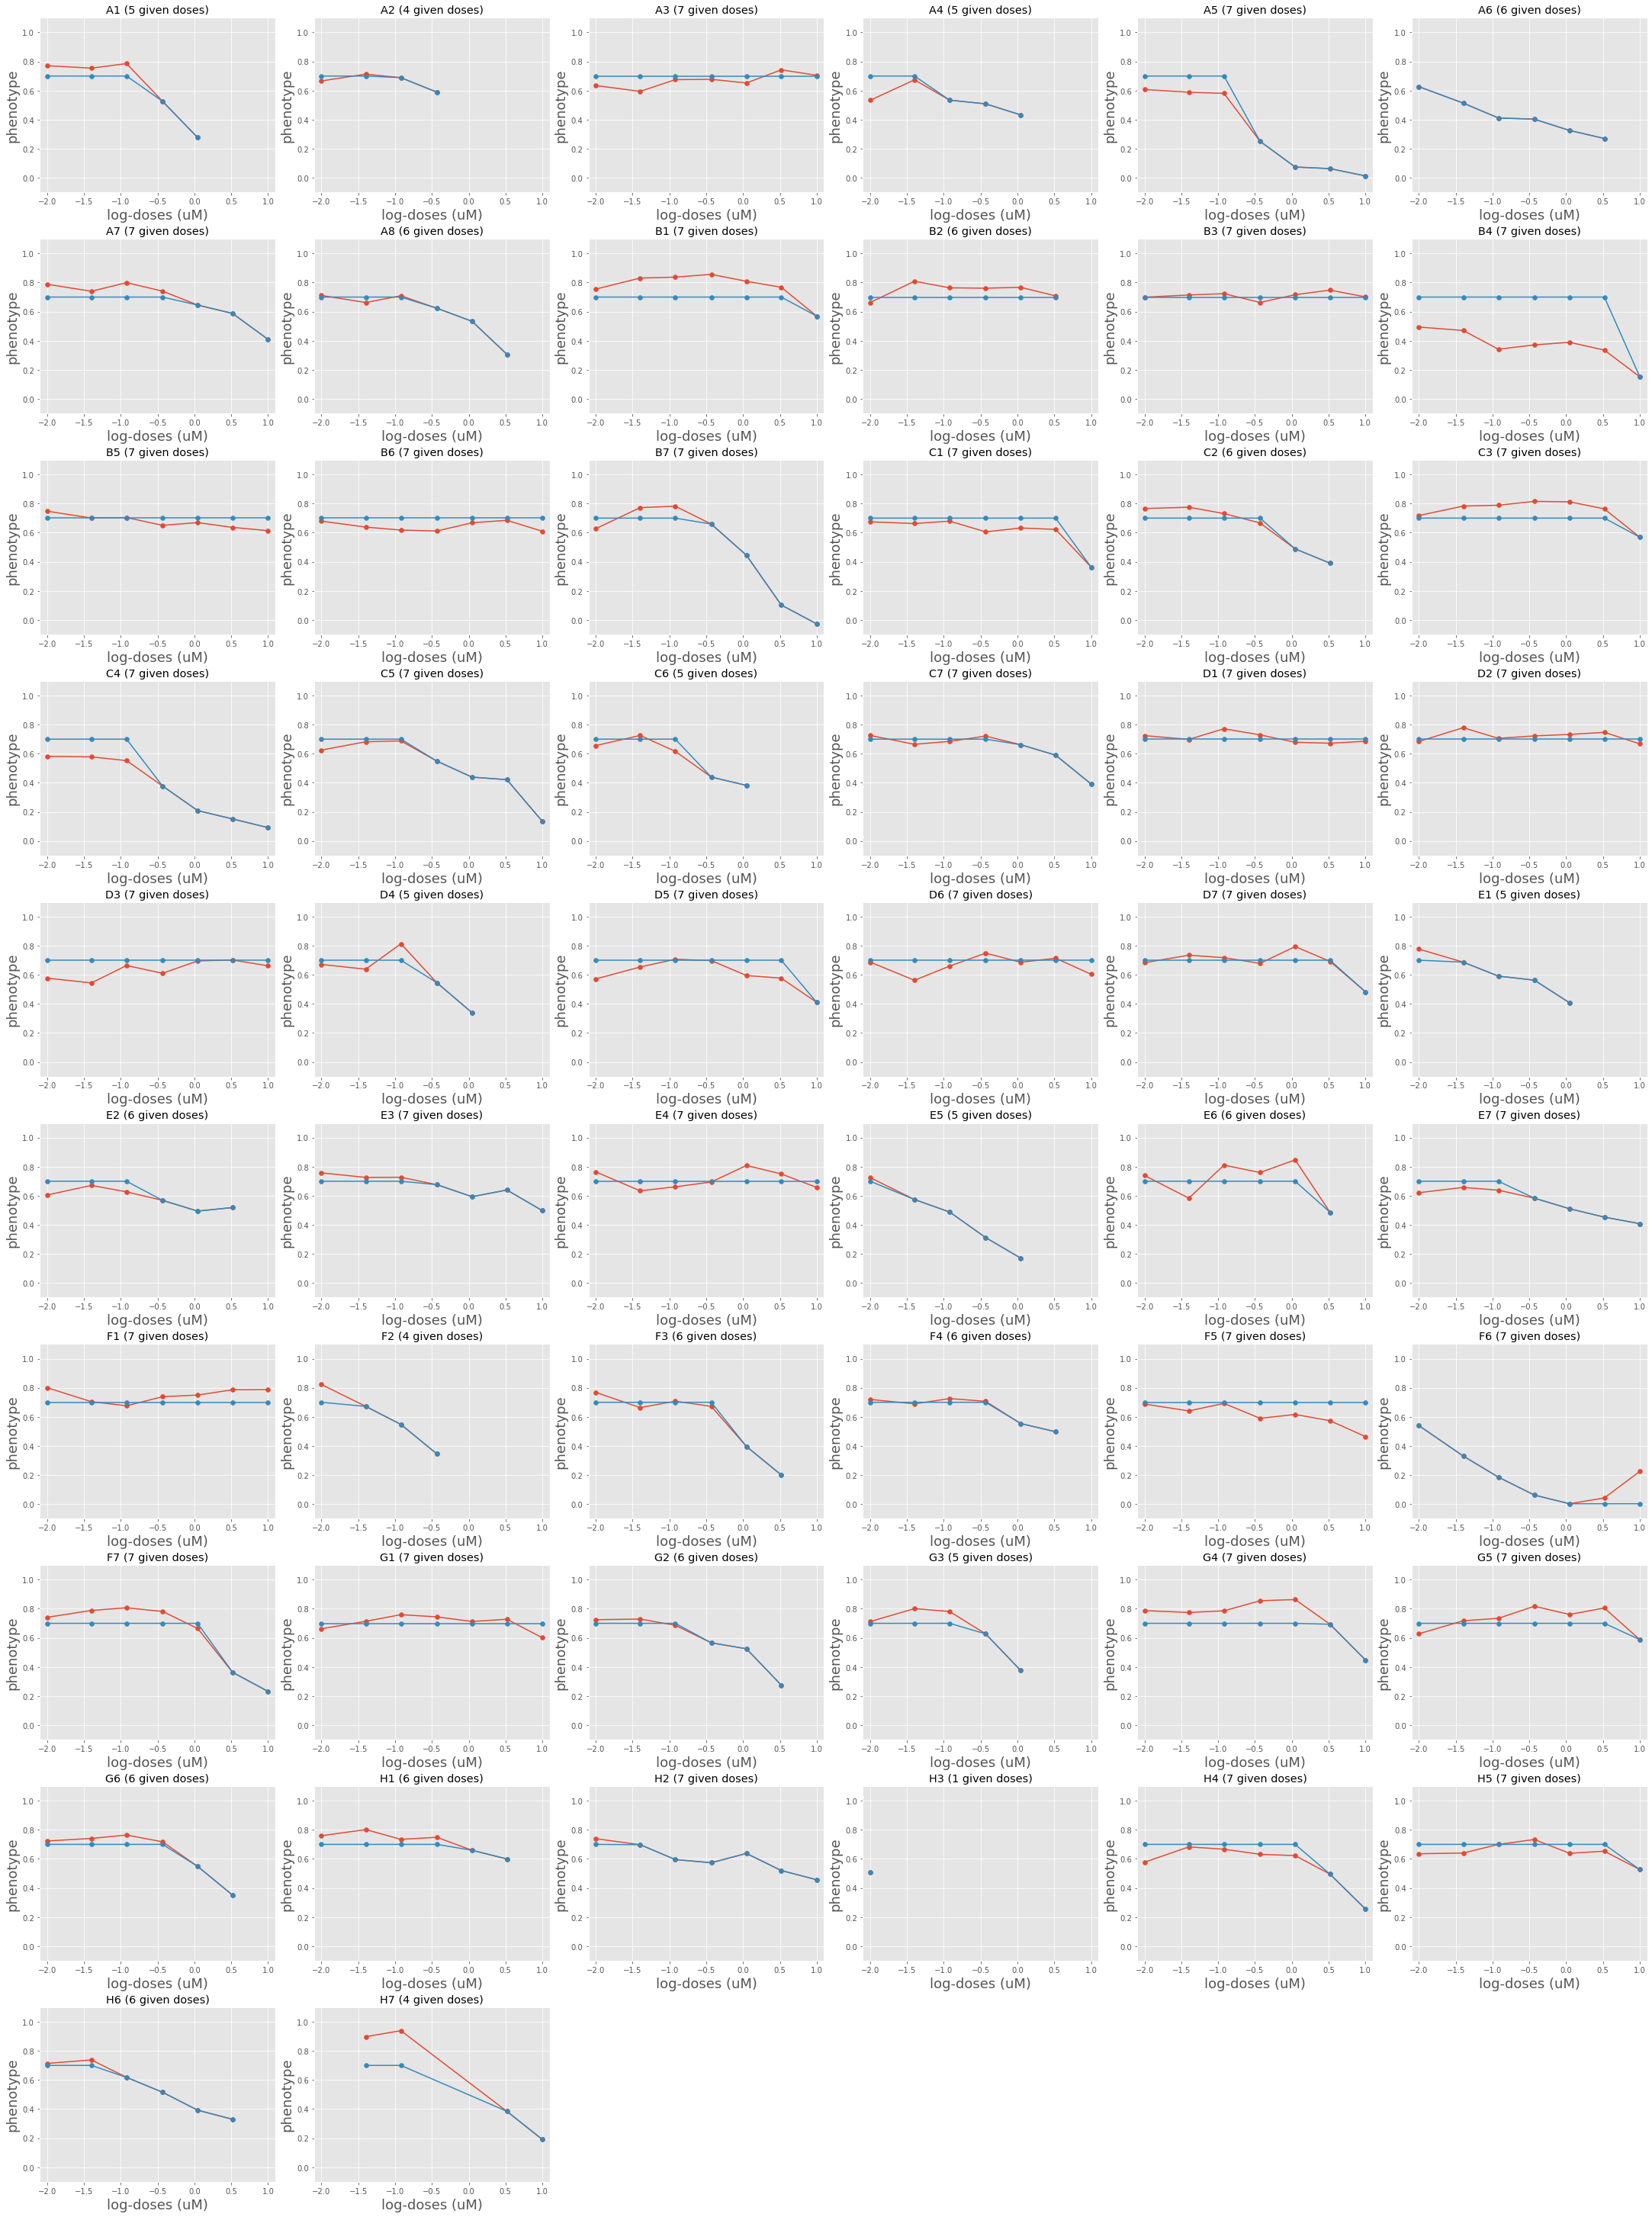

In [10]:
%matplotlib inline
plot_medicines([y_raw_interpol, y], drug_doses, drug_names, log_dose=True, save=False)

In [11]:
# for convenience here one can see how doses and log-doses are related 
# {x: np.log10(x) for x in [0.01, 0.04, 0.12, 0.37, 1.11, 3.3, 10]}

## Preprocessing of the phenotype: find good medicines and doses

In [12]:
name_2_short_name = {name: short_name  for name, short_name in 
                     zip(drug_phenotype_df['drugNames'], drug_phenotype_df['drugShortNames'])}


In [13]:
bad_medicines = ['C1', 'B5', 'F2', 'A7', 'H2', 'D1', 'D7', 'H7', 'H3']
medicines_with_suspicious_last_doses = ['F5', 'B4', 'H5', 'G1', 'G5', 'G4', 
                                        'D6', 'D2', 'D5', 'E7', 'F7', 'B7', 'D7', 'C5']

medicines_doses_mask = good_medicines_and_doses_mask(drug_doses, drug_names, 
                             medicines_with_suspicious_last_doses, bad_medicines, False)


only_largest_dose_on_plateau_mask = find_mask_of_k_largest_doses_with_no_phenotype(y, drug_names, drug_doses, k=1)
final_mask = medicines_doses_mask & only_largest_dose_on_plateau_mask


print(f'{np.sum(~only_largest_dose_on_plateau_mask)} were thrown out from the plateaus.')
print(f'Remaining points: {final_mask.sum()}')
print(f'{np.sum(~medicines_doses_mask)} were thrown out because of high noise')

237 were thrown out from the plateaus.
Remaining points: 131
73 were thrown out because of high noise


In [14]:
medicines_doses_mask.rename('if_used_in_final').to_csv(path + 'good_doses_mask.csv', index=False)

In [15]:
final_mask.rename('if_used_in_final').to_csv(path + 'final_mask_1_point_on_plateau.csv', index=False)

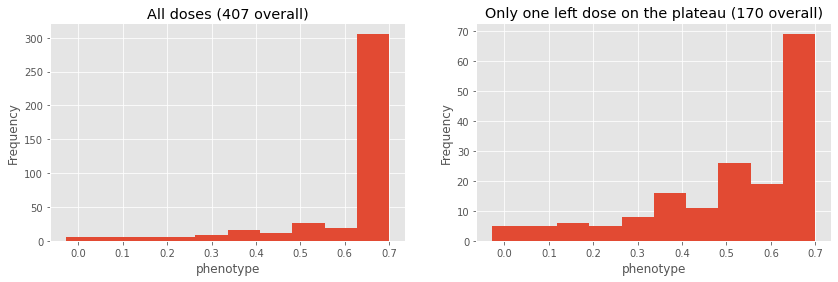

In [16]:
%matplotlib inline
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))

ax[0].hist(y, bins=10)
ax[0].set_xlabel('phenotype')
ax[0].set_ylabel('Frequency')
ax[0].set_title(f'All doses ({len(y)} overall)')

ax[1].hist(y[only_largest_dose_on_plateau_mask], bins=10)
ax[1].set_xlabel('phenotype')
ax[1].set_ylabel('Frequency')
ax[1].set_title(f'Only one left dose on the plateau ({sum(only_largest_dose_on_plateau_mask)} overall)')
# plt.savefig('dose_comparison.png', dpi=200)
plt.show()



In [18]:
print(f'Proportion of close to control values for the whole data is ', round(np.mean(y > 0.69), 2))
print('Proportion of close to control values for the cleaned data is ',
      round(np.mean(y[only_largest_dose_on_plateau_mask] > 0.69), 2))

Proportion of close to control values for the whole data is  0.72
Proportion of close to control values for the cleaned data is  0.34
